In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import combinations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data Prep

In [24]:
data = pd.read_csv('Factors.csv')
data.set_index('Unnamed: 0', inplace=True)

for i in ['Small-Low', 'Small-High', 'Big-Low', 'Big-High', 'Market']:
    data[f'{i} Ex'] = data[i] - data['Rf']

data['Rf Ex'] = data['Rf'] # for generalization when we indec by Ex

sub1 = data.loc[1926_07:1963_12,:]
sub2 = data.loc[1964_01:2024_02,:]

In [25]:
def min_var(cov):
    #cov is inv-cov
    l = len(cov)
    return (cov @ np.ones(l))/(np.ones(l) @ data_cov_inv @ np.ones(l))

def mean_var(cov, mean):
    #cov is inv-cov
    l = len(cov)
    return (cov @ mean)/(np.ones(l) @ cov @ mean)

def mean_var_rf(cov, mean, rf):
    #returns weight on rf asset
    A = min_var(cov)
    B = mean_var(cov, mean)
    l = len(cov)
    return (1 / (B - A * rf)) @ cov @ (mean - rf * np.ones(l))

def port_mean(weights, means):
    return weights @ means

def port_var(weights, cov):
    #cov is inv-cov
    return weights @ cov @ weights


# def port_beta(weights, cov, off=0):
#     # last entry is market 
#     D = np.linalg.inv(np.diag(np.sqrt(np.diag(data_cov))))
#     corr = D @ data_cov @ D
#     return np.sum(weights * corr[-1-off])

def port_beta(weights, cov):
    betas = cov[4]/cov[4][4]
    return np.sum(weights * betas)

In [60]:
def plot(data_mean_var, data_min_var, data_cov, data_means, portfolios):

    front = []
    for i in np.linspace(-0.5, 1.5, 500): # frontier
        weights_new = i*data_mean_var + (1-i)*data_min_var
        front.append((port_mean(weights_new, data_means), np.sqrt(port_var(weights_new, data_cov))))
    
    front = np.array(front).T
    
    fig, ax = plt.subplots()
    #mean var
    ax.scatter(np.sqrt(port_var(data_mean_var, data_cov)), 
               port_mean(data_mean_var, data_means))
    ax.annotate('Mean-Var',
               (np.sqrt(port_var(data_mean_var, data_cov)), 
               port_mean(data_mean_var, data_means)))
    #min var
    ax.scatter(np.sqrt(port_var(data_min_var, data_cov)), 
               port_mean(data_min_var, data_means))
    ax.annotate('Min-Var',
               (np.sqrt(port_var(data_min_var, data_cov)), 
               port_mean(data_min_var, data_means)))
    
    for i in range(0,len(portfolios)):
        ax.scatter(np.sqrt(data_cov[i][i]), data_means[i])
        ax.annotate(portfolios[i], (np.sqrt(data_cov[i][i]), data_means[i]))
    
    #frontier
    ax.plot(front[1], front[0])

    ax.set_ylabel('Mean Excess Return')
    ax.set_xlabel('Standard Deviation of Excess Return')
    
    ax.grid(color='white')
    ax.set_facecolor((0.90,0.90,0.95))
    fig.show()

    
    print('Mean-Var Sharpe:', port_mean(data_mean_var, data_means)/np.sqrt(port_var(data_mean_var, data_cov)))
    print('Market Sharpe:', data_means[4]/np.sqrt(data_cov[4][4]))

In [27]:
def plot_betas(data_mean_var, data_min_var, data_cov, data_means, portfolios, rf, w=None):
    off = 0
    if w is not None:
        data_mean_var = data_mean_var*(1-w) 
        data_mean_var = np.append(data_mean_var, w)
        data_min_var = np.append(data_min_var, 0)
        off = 1
    
    fig, ax = plt.subplots()
    #mean var
    ax.scatter(port_beta(data_mean_var, data_cov), 
               port_mean(data_mean_var, data_means))
    ax.annotate('Mean-Var',
               (port_beta(data_mean_var, data_cov), 
               port_mean(data_mean_var, data_means)))
    #min var
    ax.scatter(port_beta(data_min_var, data_cov), 
               port_mean(data_min_var, data_means))
    ax.annotate('Min-Var',
               (port_beta(data_min_var, data_cov), 
               port_mean(data_min_var, data_means)))

    # D = np.linalg.inv(np.diag(np.sqrt(np.diag(data_cov))))
    # corr = (D @ data_cov @ D)[-1-off]
    
    for i in range(0,len(portfolios)):
        beta = data_cov[i][4] / data_cov[4][4]
        ax.scatter(beta, data_means[i])
        ax.annotate(portfolios[i], (beta, data_means[i]))
    
    
    ax.grid(color='white')
    ax.set_facecolor((0.90,0.90,0.95))

    ax.set_ylabel('Mean')
    ax.set_xlabel('Beta')
    fig.show()

# A) Mean-Var and Min-Var Portfolios (No RF)

In [28]:
portfolios = ['Small-Low', 'Small-High', 'Big-Low', 'Big-High', 'Market']

In [29]:
data_cov = np.cov(data[[f'{i} Ex' for i in portfolios]].T)
data_means = [data[f'{i} Ex'].mean() for i in portfolios]

sub1_cov = np.cov(sub1[[f'{i} Ex' for i in portfolios]].T)
sub1_means = [sub1[f'{i} Ex'].mean() for i in portfolios]

sub2_cov = np.cov(sub2[[f'{i} Ex' for i in portfolios]].T)
sub2_means = [sub2[f'{i} Ex'].mean() for i in portfolios]

In [30]:
data_cov

array([[56.00322622, 54.04270248, 33.79431128, 43.12079337, 35.57584022],
       [54.04270248, 65.8914104 , 33.61074396, 53.13058654, 37.51227782],
       [33.79431128, 33.61074396, 28.1622775 , 31.1783589 , 27.71428689],
       [43.12079337, 53.13058654, 31.1783589 , 50.9306339 , 34.44523584],
       [35.57584022, 37.51227782, 27.71428689, 34.44523584, 28.5323145 ]])

In [31]:
data_cov_inv = np.linalg.inv(data_cov)
data_min_var = min_var(data_cov_inv)
data_mean_var = mean_var(data_cov_inv, data_means)

sub1_cov_inv = np.linalg.inv(sub1_cov)
sub1_min_var = min_var(sub1_cov_inv)
sub1_mean_var = mean_var(sub1_cov_inv, sub1_means)

sub2_cov_inv = np.linalg.inv(sub2_cov)
sub2_min_var = min_var(sub2_cov_inv)
sub2_mean_var = mean_var(sub2_cov_inv, sub2_means)

/tmp/ipykernel_106166/727807247.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Mean-Var Sharpe: 0.18975182993766995
Market Sharpe: 0.023897519277019923


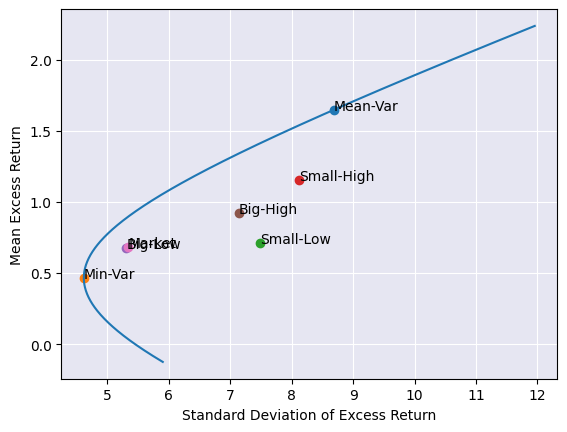

In [32]:
plot(data_mean_var, data_min_var, data_cov, data_means, portfolios)

/tmp/ipykernel_106166/1597628353.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


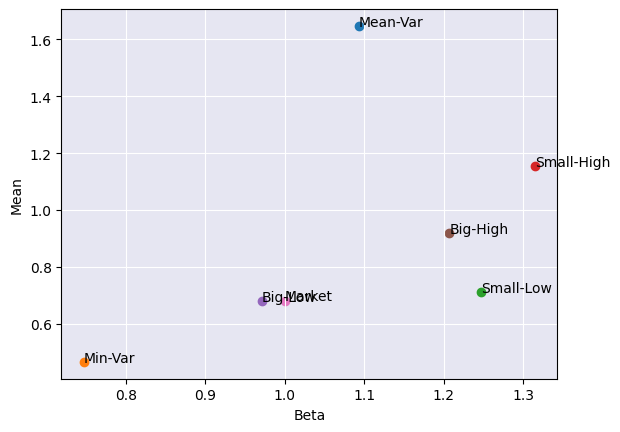

In [33]:
plot_betas(data_mean_var, data_min_var, data_cov, data_means, portfolios, data['Rf'].mean())

In [34]:
# Some alpha printing
rf = data['Rf'].mean()
for j, i in enumerate(portfolios):
    beta = data_cov[j][4] / data_cov[4][4]
    print(f'{i} Alpha:', data[i].mean() - rf - (beta * data_means[4]))

Small-Low Alpha: -0.13881698965042077
Small-High Alpha: 0.2582968873940533
Big-Low Alpha: 0.016262311847456523
Big-High Alpha: 0.09680011465642158
Market Alpha: 0.0


Mean-Var Sharpe: 0.16005731457776878
Market Sharpe: 0.0206373201330177


/tmp/ipykernel_106166/727807247.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


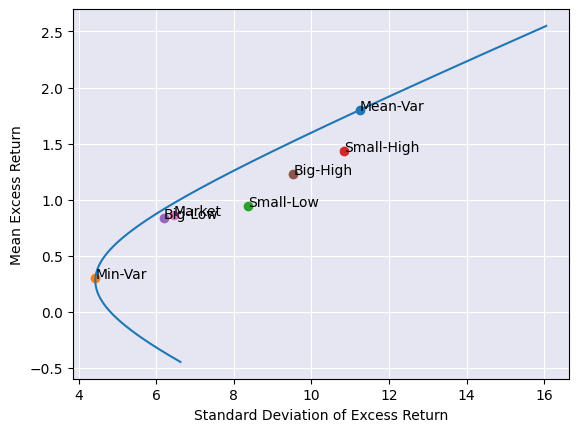

In [35]:
plot(sub1_mean_var, sub1_min_var, sub1_cov, sub1_means, portfolios)

/tmp/ipykernel_106166/1597628353.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


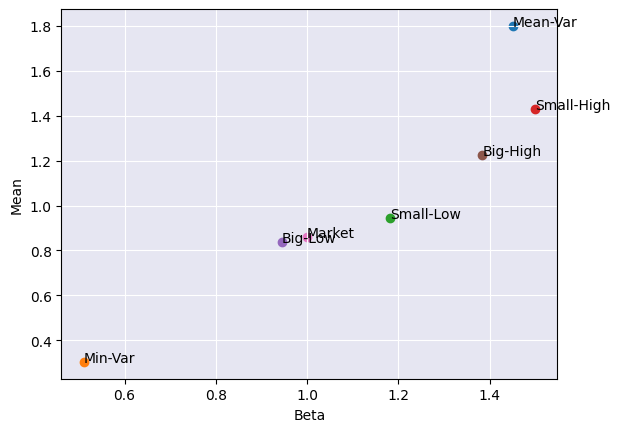

In [36]:
plot_betas(sub1_mean_var, sub1_min_var, sub1_cov, sub1_means, portfolios, sub1['Rf'].mean())

In [37]:
# Some alpha printing
rf = sub1['Rf'].mean()
for j, i in enumerate(portfolios):
    beta = sub1_cov[j][4] / sub1_cov[4][4]
    print(f'{i} Alpha:', sub1[i].mean() - rf - (beta * sub1_means[4]))

Small-Low Alpha: -0.07469969257985032
Small-High Alpha: 0.1408911883697448
Big-Low Alpha: 0.022202467165185036
Big-High Alpha: 0.03488335803886766
Market Alpha: -3.3306690738754696e-16


Mean-Var Sharpe: 0.26563070546664197
Market Sharpe: 0.0280541041491805


/tmp/ipykernel_106166/727807247.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


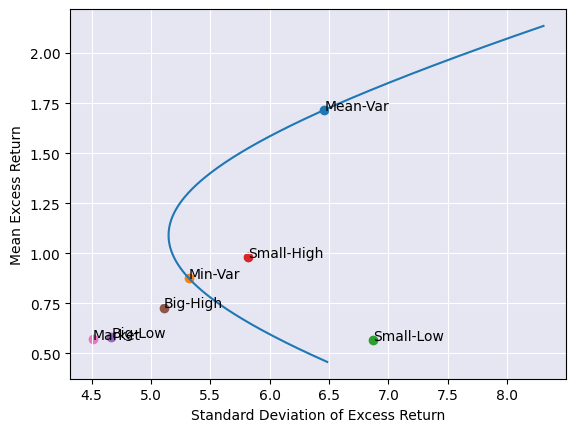

In [38]:
plot(sub2_mean_var, sub2_min_var, sub2_cov, sub2_means, portfolios)

/tmp/ipykernel_106166/1597628353.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


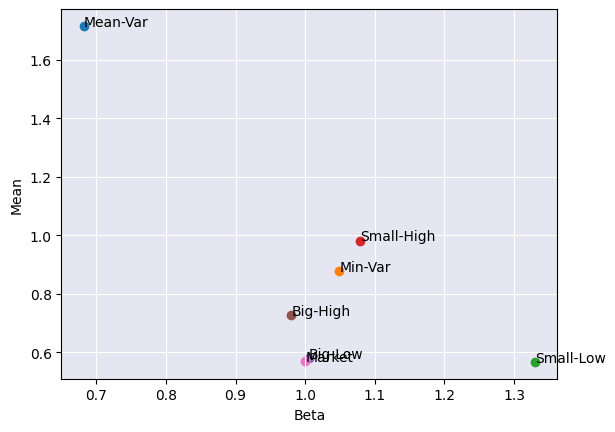

In [39]:
plot_betas(sub2_mean_var, sub2_min_var, sub2_cov, sub2_means, portfolios, sub2['Rf'].mean())

In [40]:
# Some alpha printing
rf = sub2['Rf'].mean()
for j, i in enumerate(portfolios):
    beta = sub2_cov[j][4] / sub2_cov[4][4]
    print(f'{i} Alpha:', sub2[i].mean() - rf - (beta * sub2_means[4]))

Small-Low Alpha: -0.19123239279780013
Small-High Alpha: 0.367164483371066
Big-Low Alpha: 0.007455718614618134
Big-High Alpha: 0.1698651744195091
Market Alpha: 0.0


# Mean-Var and Min-Var Portfolios (RF)

In [41]:
portfolios = ['Small-Low', 'Small-High', 'Big-Low', 'Big-High', 'Market']

In [42]:
data_cov = np.cov(data[[f'{i} Ex' for i in portfolios]].T)
data_means = [data[f'{i} Ex'].mean() for i in portfolios]

sub1_cov = np.cov(sub1[[f'{i} Ex' for i in portfolios]].T)
sub1_means = [sub1[f'{i} Ex'].mean() for i in portfolios]

sub2_cov = np.cov(sub2[[f'{i} Ex' for i in portfolios]].T)
sub2_means = [sub2[f'{i} Ex'].mean() for i in portfolios]

In [43]:
data_cov_inv = np.linalg.inv(data_cov)
data_min_var = min_var(data_cov_inv)
data_mean_var = mean_var(data_cov_inv, data_means)
data_w = mean_var_rf(data_cov_inv, data_means, data['Rf'].mean())

sub1_cov_inv = np.linalg.inv(sub1_cov)
sub1_min_var = min_var(sub1_cov_inv)
sub1_mean_var = mean_var(sub1_cov_inv, sub1_means)
sub1_w = mean_var_rf(sub1_cov_inv, sub1_means, sub1['Rf'].mean())

sub2_cov_inv = np.linalg.inv(sub2_cov)
sub2_min_var = min_var(sub2_cov_inv)
sub2_mean_var = mean_var(sub2_cov_inv, sub2_means)
sub2_w = mean_var_rf(sub2_cov_inv, sub2_means, sub2['Rf'].mean())

In [44]:
data_cov = np.cov(data[[f'{i} Ex' for i in portfolios + ['Rf']]].T)
data_means = [data[f'{i} Ex'].mean() for i in portfolios + ['Rf']]

sub1_cov = np.cov(sub1[[f'{i} Ex' for i in portfolios + ['Rf']]].T)
sub1_means = [sub1[f'{i} Ex'].mean() for i in portfolios + ['Rf']]

sub2_cov = np.cov(sub2[[f'{i} Ex' for i in portfolios + ['Rf']]].T)
sub2_means = [sub2[f'{i} Ex'].mean() for i in portfolios + ['Rf']]

In [45]:
def plot_rf(data_mean_var, data_min_var, data_cov, data_means, portfolios, w, rf):

    data_mean_var = data_mean_var*(1-w) 
    data_mean_var = np.append(data_mean_var, w)
    data_min_var = np.append(data_min_var, 0)
    
    front = []
    for i in np.linspace(-0.5, 1.5, 500): # frontier
        weights_new = i*data_mean_var + (1-i)*data_min_var
        front.append((port_mean(weights_new, data_means), np.sqrt(port_var(weights_new, data_cov))))
    
    front = np.array(front).T
    
    fig, ax = plt.subplots()
    #mean var
    ax.scatter(np.sqrt(port_var(data_mean_var, data_cov)), 
               port_mean(data_mean_var, data_means))
    ax.annotate('Mean-Var',
               (np.sqrt(port_var(data_mean_var, data_cov)), 
               port_mean(data_mean_var, data_means)))
    #min var
    ax.scatter(np.sqrt(port_var(data_min_var, data_cov)), 
               port_mean(data_min_var, data_means))
    ax.annotate('Min-Var',
               (np.sqrt(port_var(data_min_var, data_cov)), 
               port_mean(data_min_var, data_means)))
    
    for i in range(0,len(portfolios)):
        ax.scatter(np.sqrt(data_cov[i][i]), data_means[i])
        ax.annotate(portfolios[i], (np.sqrt(data_cov[i][i]), data_means[i]))
    
    #frontier
    ax.plot(front[1], front[0])

    ax.set_ylabel('Mean Excess Return')
    ax.set_xlabel('Standard Deviation of Excess Return')
    ax.grid(color='white')
    ax.set_facecolor((0.90,0.90,0.95))
    fig.show()

    print('Mean-Var Sharpe:', port_mean(data_mean_var, data_means)/np.sqrt(port_var(data_mean_var, data_cov)))
    print('Market Sharpe:', data_means[4]/np.sqrt(data_cov[4][4]))

/tmp/ipykernel_106166/1654822659.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


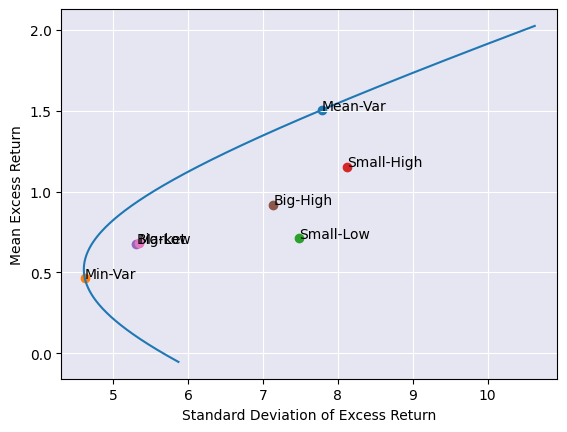

In [46]:
plot_rf(data_mean_var, data_min_var, data_cov, data_means, portfolios, data_w, data['Rf'].mean())

/tmp/ipykernel_106166/1597628353.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


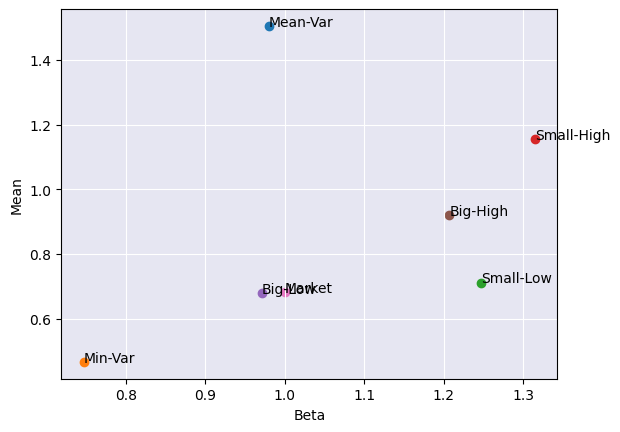

In [47]:
plot_betas(data_mean_var, data_min_var, data_cov, data_means, portfolios, data['Rf'].mean(), data_w)

In [48]:
# Some alpha printing
rf = data['Rf'].mean()
for j, i in enumerate(portfolios):
    beta = data_cov[j][4] / data_cov[4][4]
    print(f'{i} Alpha:', data[i].mean() - rf - (beta * data_means[4]))

Small-Low Alpha: -0.13881698965042077
Small-High Alpha: 0.2582968873940533
Big-Low Alpha: 0.016262311847456523
Big-High Alpha: 0.09680011465642158
Market Alpha: 0.0


/tmp/ipykernel_106166/1654822659.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


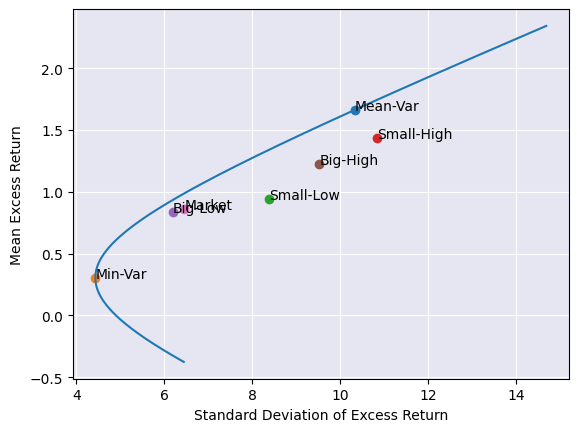

In [49]:
plot_rf(sub1_mean_var, sub1_min_var, sub1_cov, sub1_means, portfolios, sub1_w, sub1['Rf'].mean())

/tmp/ipykernel_106166/1597628353.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


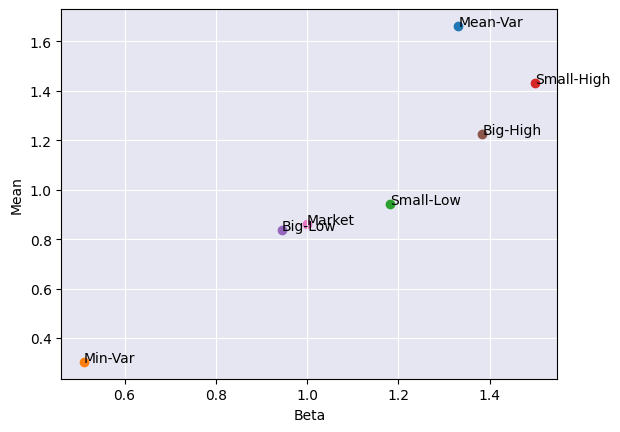

In [50]:
plot_betas(sub1_mean_var, sub1_min_var, sub1_cov, sub1_means, portfolios, sub1['Rf'].mean(), sub1_w)

In [51]:
# Some alpha printing
rf = sub1['Rf'].mean()
for j, i in enumerate(portfolios):
    beta = sub1_cov[j][4] / sub1_cov[4][4]
    print(f'{i} Alpha:', sub1[i].mean() - rf - (beta * sub1_means[4]))

Small-Low Alpha: -0.07469969257985032
Small-High Alpha: 0.1408911883697448
Big-Low Alpha: 0.022202467165185036
Big-High Alpha: 0.03488335803886766
Market Alpha: -3.3306690738754696e-16


/tmp/ipykernel_106166/1654822659.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


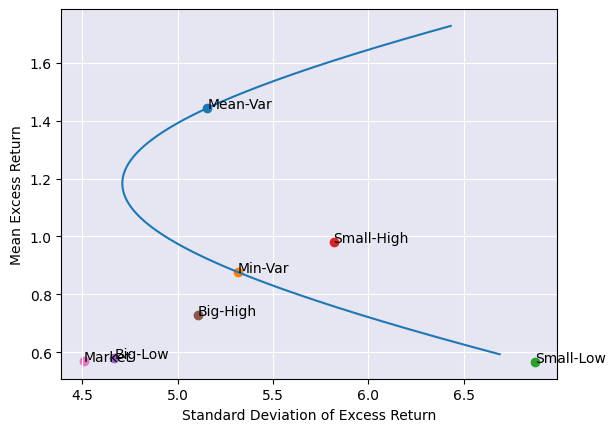

In [52]:
plot_rf(sub2_mean_var, sub2_min_var, sub2_cov, sub2_means, portfolios, sub2_w, sub2['Rf'].mean)

/tmp/ipykernel_106166/1597628353.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


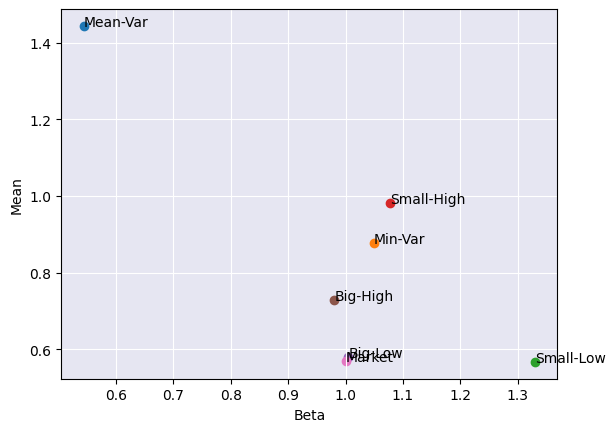

In [53]:
plot_betas(sub2_mean_var, sub2_min_var, sub2_cov, sub2_means, portfolios, sub2['Rf'].mean(), sub2_w)

In [54]:
# Some alpha printing
rf = sub2['Rf'].mean()
for j, i in enumerate(portfolios):
    beta = sub2_cov[j][4] / sub2_cov[4][4]
    print(f'{i} Alpha:', sub2[i].mean() - rf - (beta * sub2_means[4]))

Small-Low Alpha: -0.19123239279780013
Small-High Alpha: 0.367164483371066
Big-Low Alpha: 0.007455718614618134
Big-High Alpha: 0.1698651744195091
Market Alpha: 0.0


## Part A Discussion

When looking at the Alphas and the Betas of our results we see a few interesting trends. Pre 1964 the betas in the market were quite variable, yet the alphas were small. Almost paradoxically, we see that post 1964 our betas shrink, all portfolios move more in sync with the market, yet alpha emerges. Most notably it was the betas of the small cap stocks that shifted to 1 the most.


# B

/tmp/ipykernel_106166/1207171088.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


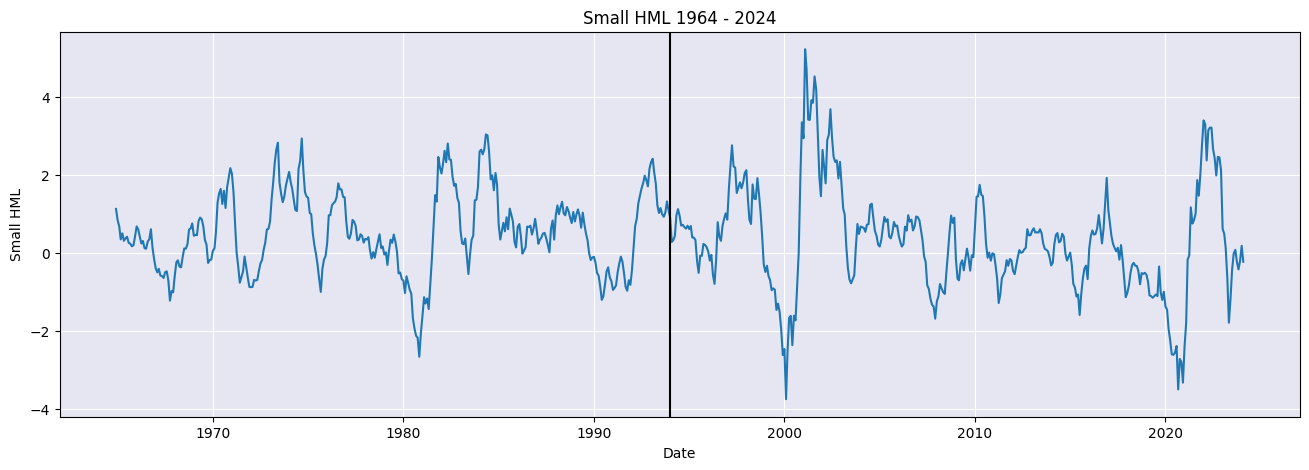

In [55]:
fig, ax = plt.subplots(figsize=(16,5))
ax.grid(color='white')
ax.set_facecolor((0.90,0.90,0.95))
ax.plot(pd.to_datetime(sub2.index, format='%Y%m'), 
        (sub2['Small-High'] - sub2['Small-Low']).rolling(12).mean())

ax.axvline(pd.to_datetime('1994-01-01'), c='black')

ax.set_ylabel('Small HML')
ax.set_xlabel('Date')
ax.set_title('Small HML 1964 - 2024')

fig.show()

In [56]:
print("Mean & Std. & Sharpe Ratio for Market Portfolio \n")

split = 199312
ret_period1=sub2.loc[:split,"Market"] - sub2.loc[:split,"Rf"]
ret_period2=sub2.loc[split:,"Market"] - sub2.loc[split:,"Rf"]

print("1964/01-1993/12")
print(f"mean={ret_period1.mean()}, std={ret_period1.std()}, sharpe ratio={ret_period1.mean()/ret_period1.std()}\n")

print("1994/01-2024/02")
print(f"mean={ret_period2.mean()}, std={ret_period2.std()}, sharpe ratio={ret_period2.mean()/ret_period2.std()}\n")

print("Mean & Std. & Sharpe Ratio for Small HML")

hml_period1=sub2.loc[:split,"Small-High"] - sub2.loc[:split,"Small-Low"]
hml_period2=sub2.loc[split:,"Small-High"] - sub2.loc[split:,"Small-Low"]

print("1964/01-1993/12")
print(f"mean={hml_period1.mean()}, std={hml_period1.std()}, sharpe ratio={hml_period1.mean()/hml_period1.std()}\n")

print("1994/01-2024/02")
print(f"mean={hml_period2.mean()}, std={hml_period2.std()}, sharpe ratio={hml_period2.mean()/hml_period2.std()}\n")


Mean & Std. & Sharpe Ratio for Market Portfolio 

1964/01-1993/12
mean=0.40874999999999995, std=4.495393909294429, sharpe ratio=0.09092640339145608

1994/01-2024/02
mean=0.7330303030303028, std=4.514634174672781, sharpe ratio=0.16236759716714644

Mean & Std. & Sharpe Ratio for Small HML
1964/01-1993/12
mean=0.5342047222222222, std=2.8326643514198673, sharpe ratio=0.18858737073965473

1994/01-2024/02
mean=0.2952424242424242, std=3.729180892756798, sharpe ratio=0.07917085084713231



In [57]:
data.index = pd.to_datetime(data.index, format='%Y%m')
data_quarterly = data.groupby(pd.PeriodIndex(data.index, freq='Q'), axis=0).mean()

/tmp/ipykernel_106166/1430060621.py:2: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  data_quarterly = data.groupby(pd.PeriodIndex(data.index, freq='Q'), axis=0).mean()


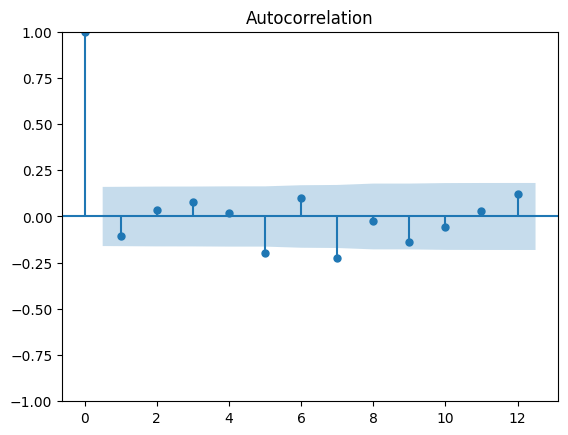

In [58]:
_ = plot_acf(data_quarterly.loc['1926Q3':'1963Q4','Small-High'] - data_quarterly.loc['1926Q3':'1963Q4','Small-Low'], lags=12)

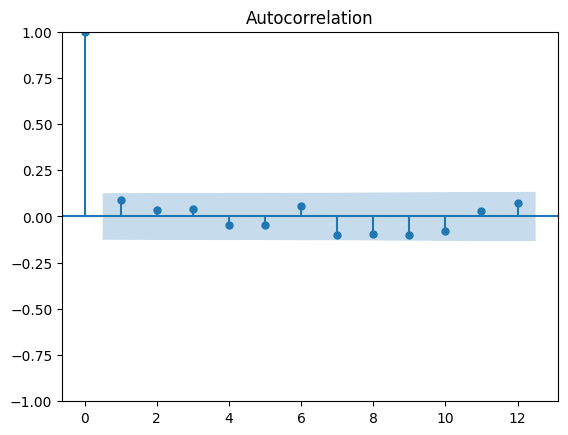

In [59]:
_ = plot_acf(data_quarterly.loc['1964Q1':,'Small-High'] - data_quarterly.loc['1964Q1':,'Small-Low'], lags=12)

In pre 1964 time we see that they have a patter with many moderatly large moves. It seems like they have a few significant autocorrelations in the 5 and 7 quarter ranges. Post 1964 we seea shift, in general the moves in the market are smaller, however, in times of crisis the moves have become much larger. We also see that there are no longer any significant autocorrelations. Hence, we observe the market become more random over time in general, but much more correlated in times of crisis. This shadows the behavior of the market as it becomes more efficent and more globalized/interconnected at the same time. 

# C 

Duration figure doesn't complicate or conflict with the observation of declining value investments. The figure on page 1413 shows cumulative alphas and after 1994. The slope starts to decline which indicates lower alpha within the recent periods. This consists with declining value investments given price is pushed up due to quant investments and other factors.